In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../gefera')
import gefera as gf

In [2]:
t = np.linspace(90.5, 92, 1000)
#t2 = t1 + 365
#t = np.hstack((t1, t2))

a1 = 1.0
t1 = 0.2
e1 = 0.0
p1 = 365
w1 = 0.1 * np.pi / 180
i1 = 90.0 * np.pi / 180

a2 = 2.0
t2 = 0.25
e2 = 0.0
p2 = 365
om2 = 0.1 * np.pi / 180
w2 = 0.1 * np.pi / 180
i2 = 89.99 * np.pi / 180

u1 = 0.5
u2 = 0.3
r1 = 0.2
r2 = 0.1

In [27]:
o1 = gf.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
o2 = gf.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
sys = gf.ConfocalSystem(o1, o2)
%time lc_ng = sys.lightcurve(t, u1, u2, r1, r2)
%time lc = sys.lightcurve(t, u1, u2, r1, r2, grad=True)[0]
y = lc + np.random.randn(len(lc)) * 0.005

CPU times: user 1.2 ms, sys: 829 µs, total: 2.03 ms
Wall time: 1.15 ms
CPU times: user 2.63 ms, sys: 2.57 ms, total: 5.2 ms
Wall time: 4.91 ms


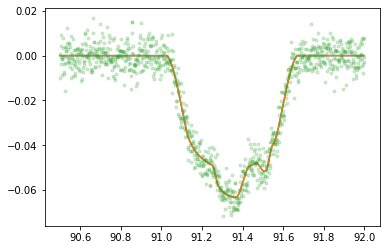

In [28]:
plt.plot(t, lc)
plt.plot(t, lc_ng)
plt.plot(t, y, '.', alpha=0.2)

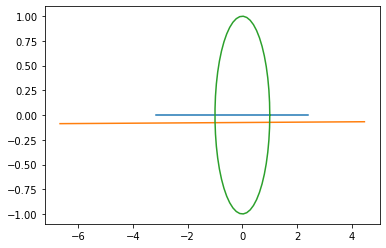

In [29]:
(x1, y1, z1), (x2, y2, z2) = sys.coords(t)
plt.plot(x1, y1)
plt.plot(x2, y2)

th = np.linspace(0, 2 * np.pi)
plt.plot(np.cos(th), np.sin(th))
#plt.xlim(-2, 2)

In [31]:
uniform = lambda x, l, u: 0.0 if ((x >= l) & (x <= u)) else -np.inf

def log_prior(args):
    
    lsigma, r1, r2, u1, u2, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2 = args
    
    prior = 0.0 if r2 < r1 and u1 + u2 < 1 and u1 > 0 and u1 + 2 * u2 > 0 else -np.inf
    
    return (prior 
            + uniform(lsigma, np.log(0.001), np.log(0.1))
            + uniform(r1, 0.15, 0.5)
            + uniform(r2, 0.0, 0.15)
            + uniform(a1, 0.5, 1.5)
            + uniform(t1, 0.0, 1.0)
            + uniform(e1, 0.0, 1.0)
            + uniform(p1, 300, 400)
            + uniform(w1, -0.0001, 0.5)
            + uniform(i1, 85 * np.pi / 180, 90.1 * np.pi / 180)
            + uniform(a2, 1.0, 3.0)
            + uniform(t2, -5.0, 5.0)
            + uniform(e2, 0.0, 1.0)
            + uniform(p2, 300, 400)
            + uniform(om2, 0.0, 0.5)
            + uniform(w2, 0.0, np.pi)
            + uniform(i2, 0.0, np.pi / 2)
    )

def log_like(args, y):
    
    lsigma, r1, r2, u1, u2, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2 = args
    o1 = gf.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
    o2 = gf.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
    sys = gf.ConfocalSystem(o1, o2)
    return sys.loglike(y, t, u1, u2, r1, r2, np.exp(lsigma))

def log_prob(args, y):
    lp = log_prior(args)
    ll = log_like(args, y)
    if np.isfinite(ll):
        return lp + ll
    else:
        return -np.inf

In [32]:
import emcee

init_params = [np.log(0.005), r1, r2, 0.5, 0.3, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2]
pos = init_params + 1e-4 * np.random.randn(50, len(init_params))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(y,)
)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [02:20<00:00, 35.47it/s]


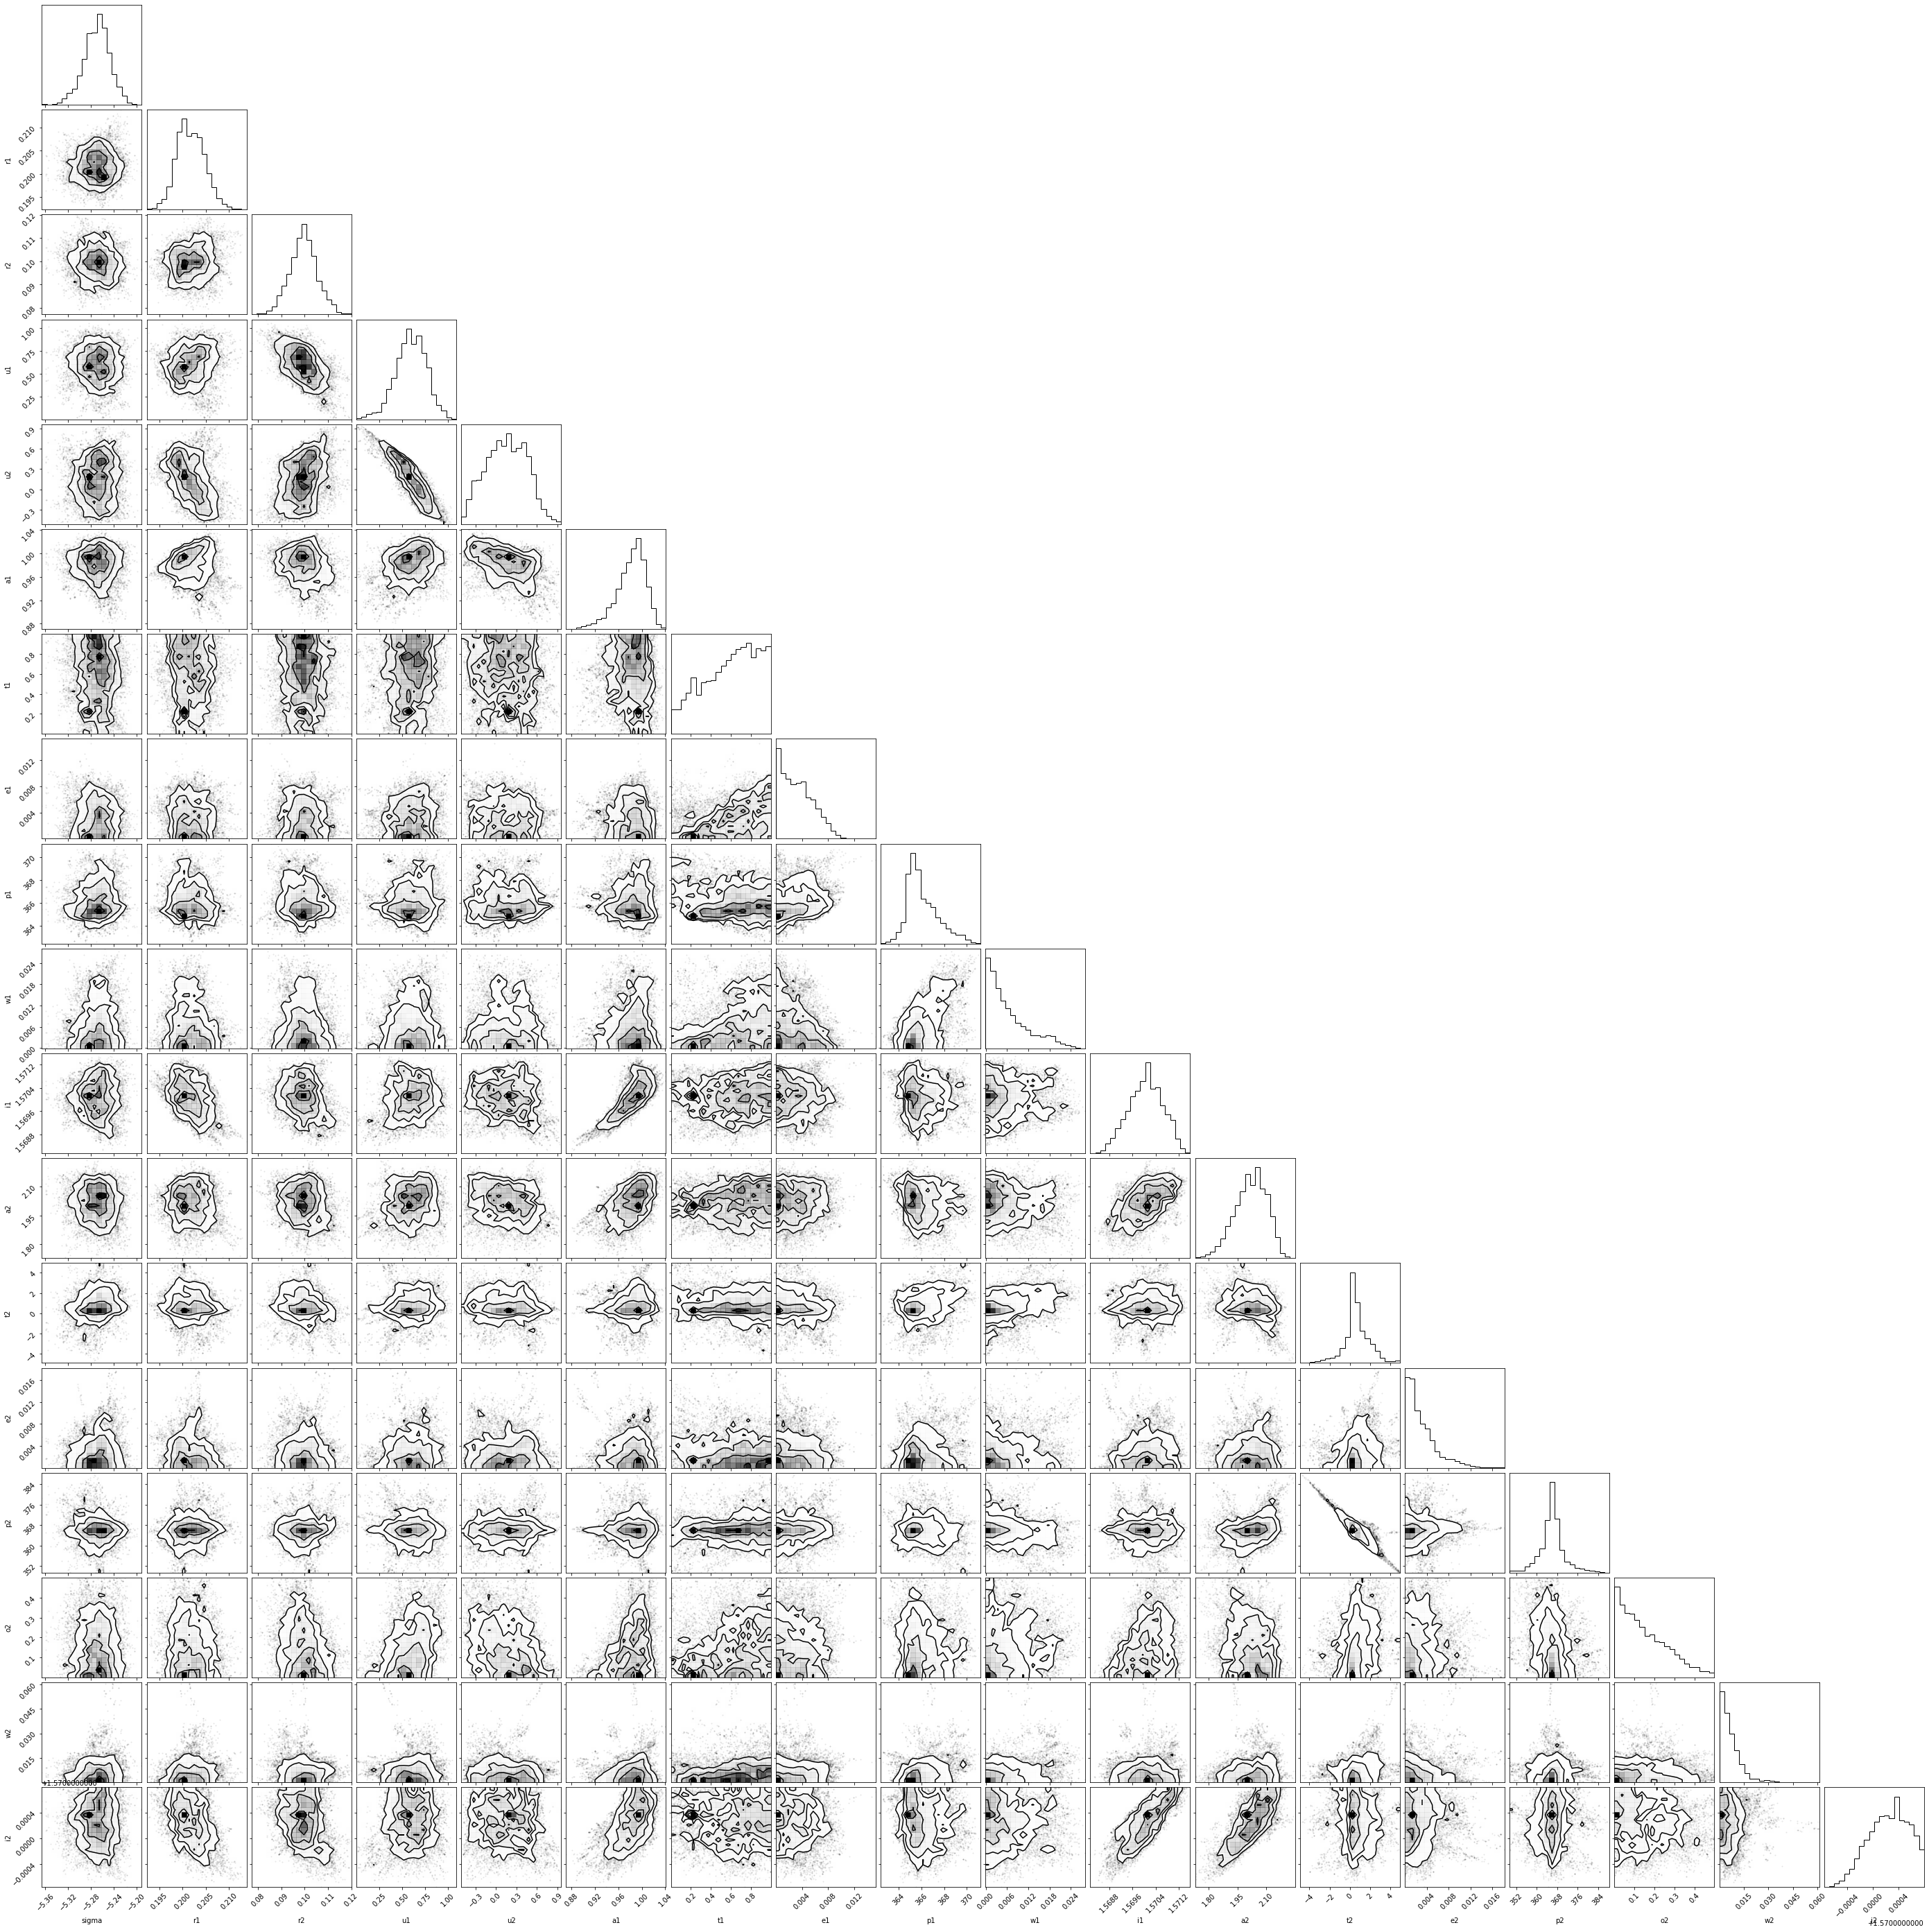

In [33]:
import corner

flat_samples = sampler.get_chain(discard=2000, thin=15, flat=True)
fig = corner.corner(
    flat_samples, 
    labels=[
        'sigma', 
        'r1', 
        'r2', 
        'u1', 
        'u2', 
        'a1', 
        't1', 
        'e1', 
        'p1', 
        'w1', 
        'i1', 
        'a2', 
        't2', 
        'e2', 
        'p2', 
        'o2', 
        'w2', 
        'i2', 
    ]
);

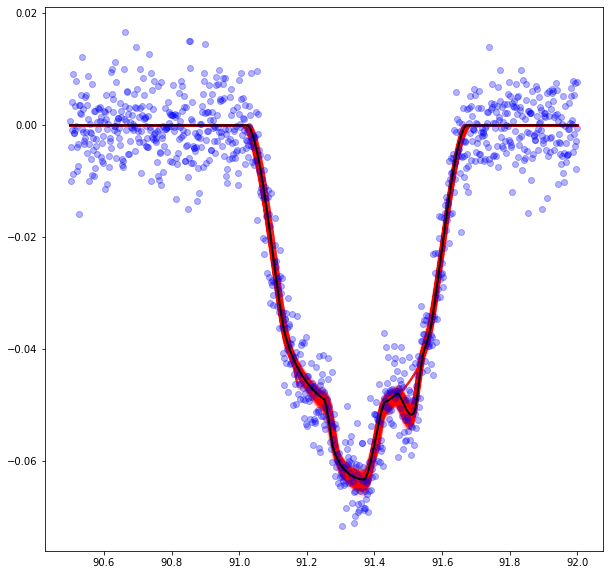

In [34]:
n = 1000
inds = np.random.randint(len(flat_samples), size=n)
samps = flat_samples[inds]

def getlc(*args):
    _, r1, r2, u1, u2, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2 = args
    o1 = gf.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
    o2 = gf.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
    sys = gf.ConfocalSystem(o1, o2)
    return sys.lightcurve(t, u1, u2, r1, r2)


plt.figure(figsize=(10, 10))
for i in range(n):
    samp = getlc(*samps[i])
    plt.plot(t, samp, color='r', linewidth=2, alpha=0.1)
    
plt.plot(t, y, 'bo', alpha=0.3)
plt.plot(t, lc, 'k-', linewidth=2)

#plt.xlim(67.8, 68.8)
#plt.savefig('/Users/tgordon/Desktop/emcee_tmp.pdf')
#plt.xlim(67.8 + 365, 68.8 + 365)
#plt.savefig('/Users/tgordon/Desktop/emcee2.pdf')